# Comparing LinearRegression (OLS) with various RandomForestRegressors

The default Random Forest Regressor will not deal especially well with a noisy input (even if very simple) compared to a high bias (and normally quite limited) model like OLS.

Here we create a noisy single-variable linear input set and show how RF performs badly and how, by limiting its depth, we can make it perform as well as OLS

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
xs = np.arange(0, 100, 0.01, dtype=np.float_)
ys = xs.copy()

# generate Gaussian noise mean 0 variance 20
noise = np.random.normal(size=xs.shape[0], scale=20)
ys += noise

xs = xs.reshape(-1, 1) # reshape to a 2 dimensional, single column input as required by sklearn

## Show the noisy single-feature input data

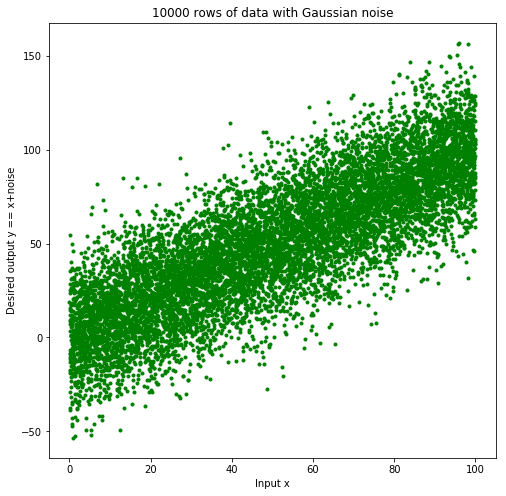

In [12]:
fig, ax = plt.subplots(figsize=(8,8));
rows = xs.shape[0]
ax.plot(xs[:, 0], ys, ".g")
ax.set_title(f"{rows} rows of data with Gaussian noise");
ax.set(xlabel="Input x", ylabel="Desired output y == x+noise");

## Create a default train/test split and train 4 estimators

In [13]:
X_train, X_test, y_train, y_test  = train_test_split(xs, ys, random_state = 0)

### OLS & RF

* Linear Regression - defaults
* RandomForestRegressor - defaults (10 estimators, unlimited depth)
* RandomForestRegressor - many estimators (unlimited depth)
* RandomForestRegressor - shallow trees (10 estimators)

In [14]:
est_lin = LinearRegression()
est_rf_default = RandomForestRegressor()
est_rf_many_trees = RandomForestRegressor(n_estimators=1000)
est_rf_shallow_trees = RandomForestRegressor(max_depth=4)
est_lin.fit(X_train, y_train)
est_rf_default.fit(X_train, y_train)
est_rf_many_trees.fit(X_train, y_train)
est_rf_shallow_trees.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Predict on the test data and generate r^2 scores

In [15]:
lin_y_pred = est_lin.predict(X_test)
rf_y_pred_default = est_rf_default.predict(X_test)
rf_y_pred_shallow_trees = est_rf_shallow_trees.predict(X_test)
rf_y_pred_many_trees = est_rf_many_trees.predict(X_test)

lin_score = est_lin.score(X_test, y_test)
rf_score_default = est_rf_default.score(X_test, y_test)
rf_score_many_trees = est_rf_many_trees.score(X_test, y_test)
rf_score_shallow_trees = est_rf_shallow_trees.score(X_test, y_test)

# Plot X_pred (inputs in test set)  against y_pred (predicted output) for each estimator

* Linear model - high bias means a very accurate prediction (as best as can be done, given the noise level)
* RandomForestRegressor with defaults - high variance as it overfits the noisy training data
* RandomForestRegressor with many trees - slightly better but still overfits
* RandomForestRegressor with shallow trees - significant variance reduction, roughly the same performace as the linear model

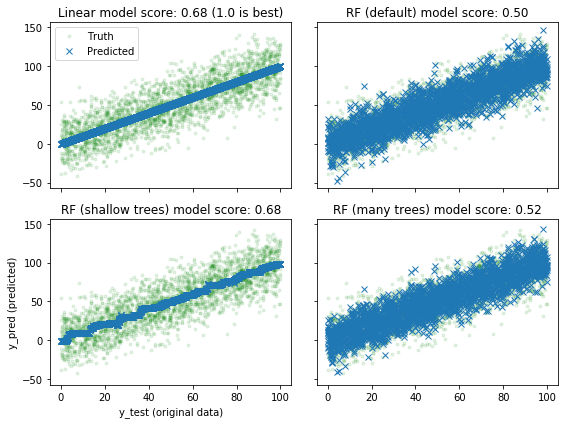

In [23]:
fig, axes = plt.subplots(figsize=(8,6), ncols=2, nrows=2, sharex=True, sharey=True);

ax0, ax1, ax2, ax3 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
ax0.plot(X_test, y_test, "g.", alpha=0.1, label="Truth")
ax0.plot(X_test, lin_y_pred, "x", label="Predicted")
ax0.set_title(f"Linear model score: {lin_score:0.2f} (1.0 is best)");
ax0.legend()

ax1.plot(X_test, y_test, "g.", alpha=0.1)
ax1.plot(X_test, rf_y_pred_default, "x")
ax1.set_title(f"RF (default) model score: {rf_score_default:0.2f}");

ax2.plot(X_test, y_test, "g.", alpha=0.1)
ax2.plot(X_test, rf_y_pred_shallow_trees, "x")
ax2.set_title(f"RF (shallow trees) model score: {rf_score_shallow_trees:0.2f}");
ax2.set(xlabel="y_test (original data)", ylabel="y_pred (predicted)")

ax3.plot(X_test, y_test, "g.", alpha=0.1)
ax3.plot(X_test, rf_y_pred_many_trees, "x")
ax3.set_title(f"RF (many trees) model score: {rf_score_many_trees:0.2f}");

fig.tight_layout()

## Plot y_pred (predictions) vs y_test (desired truth)

* Linear model - predictions are between 0 & 100 (no overspill)
* RandomForestRegressor with defaults - a more 'rounded' relationship than we'd like
* RandomForestRegressor with many trees - slightly more ovoid than the defaults
* RandomForestRegressor with shallow trees - far more like the linear model outputs

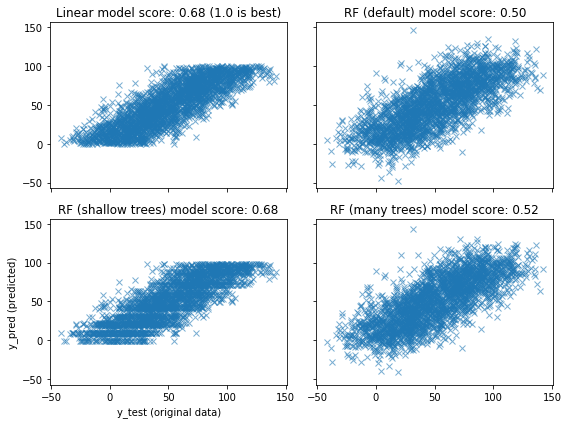

In [24]:
fig, axes = plt.subplots(figsize=(8,6), ncols=2, nrows=2, sharex=True, sharey=True);

ax0, ax1, ax2, ax3 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
ax0.plot(y_test, lin_y_pred, "x", label="lin", alpha=0.6)
ax0.set_title(f"Linear model score: {lin_score:0.2f} (1.0 is best)");

ax1.plot(y_test, rf_y_pred_default, "x", label="rf", alpha=0.6)
ax1.set_title(f"RF (default) model score: {rf_score_default:0.2f}");

ax2.plot(y_test, rf_y_pred_shallow_trees, "x", label="rf", alpha=0.6)
ax2.set_title(f"RF (shallow trees) model score: {rf_score_shallow_trees:0.2f}");
ax2.set(xlabel="y_test (original data)", ylabel="y_pred (predicted)")

ax3.plot(y_test, rf_y_pred_many_trees, "x", label="rf", alpha=0.6)
ax3.set_title(f"RF (many trees) model score: {rf_score_many_trees:0.2f}");

fig.tight_layout()